# Capstone Project: Police Call Outcome Prediction: Year 2022

This notebook explores and analyzes police call data in the city of San Jose, California, with the goal of predicting whether the outcome will be an arrest, a citation, or neither. The dataset contains various features such as call type, location, and final disposition. Models like Logistic Regression, Random Forest, and others are evaluated for this task.

## Data Loading and Initial Exploration

In this section, we load the police call dataset for analysis and perform some initial data exploration.

In [3]:
# Import necessary libraries for data manipulation, visualization, and machine learning
import warnings, os, sys
warnings.simplefilter(action='ignore', category=FutureWarning)  # Ignore future warnings

import importlib

import model_utils
importlib.reload(model_utils)

import collections
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import folium
import numpy as np
from folium.plugins import HeatMap
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
import joblib
import keras_tuner as kt
from tensorflow import keras

import optuna
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
import numpy as np
import time

### Data Loading

Here, we load the police call data for the year 2022 from a CSV file.

#### Data Source
* San Jose Police Calls For Service: https://data.sanjoseca.gov/dataset/police-calls-for-service.

In [5]:
years = [2022]
year = "2022"

all_police_df = model_utils.load_data(years)

print(f'length of dataframe = {len(all_police_df)}')

length of dataframe = 294515


### Initial Data Exploration

We explore a sample of the data and generate summary statistics to get an idea of its structure and contents.

In [7]:
all_police_df.sample(5)

,CDTS,EID,START_DATE,CALL_NUMBER,PRIORITY,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,LATITUDE,LONGITUDE,neighborhood
234055,20221013143600PD,9284835,10/13/2022 12:00:00 AM,P222860538,4,10/13/2022 12:00:00 AM,10/13/2022 12:00:00 AM,14:01:19,22500,PARKING VIOLATION,G,Gone on Arrival/unable to locate,ROYCOTT WY & COTTLE AV,San Jose,CA,37.288695,-121.892529,The Willows
283753,20221217182436PS,9366329,12/17/2022 12:00:00 AM,P223510639,3,12/17/2022 12:00:00 AM,12/17/2022 12:00:00 AM,18:08:07,1033A,"ALARM, AUDIBLE",N,No report required; dispatch record only,[600]-[700] N KING RD,San Jose,CA,37.363980,-121.865072,Las Plumas
237003,20221017130955PD,9289706,10/17/2022 12:00:00 AM,P222900371,2,10/17/2022 12:00:00 AM,10/17/2022 12:00:00 AM,11:06:55,415,DISTURBANCE,G,Gone on Arrival/unable to locate,[200]-[300] CHYNOWETH AV,San Jose,CA,37.258739,-121.827192,Oak Grove
92915,20220430014305PD,9062004,4/30/2022 12:00:00 AM,P221200045,3,4/30/2022 12:00:00 AM,4/30/2022 12:00:00 AM,00:58:35,23103,RECKLESS DRIVING,CAN,Canceled,S WINCHESTER BL & MOORPARK AV,San Jose,CA,37.315930,-121.918292,Fruitdale and Sherman Oaks
160722,20220716211547PD,9166359,7/16/2022 12:00:00 AM,P221970799,2,7/16/2022 12:00:00 AM,7/16/2022 12:00:00 AM,19:42:41,415F,"DISTURBANCE, FAMILY",R,Report taken,[3900]-[4000] THE WOODS DR,San Jose,CA,37.275120,-121.840070,The Woods


In [8]:
all_police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294515 entries, 0 to 294514
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CDTS              294515 non-null  object 
 1   EID               294515 non-null  int64  
 2   START_DATE        294515 non-null  object 
 3   CALL_NUMBER       294515 non-null  object 
 4   PRIORITY          294515 non-null  int64  
 5   REPORT_DATE       294515 non-null  object 
 6   OFFENSE_DATE      294515 non-null  object 
 7   OFFENSE_TIME      294515 non-null  object 
 8   CALLTYPE_CODE     294515 non-null  object 
 9   CALL_TYPE         294515 non-null  object 
 10  FINAL_DISPO_CODE  294515 non-null  object 
 11  FINAL_DISPO       294515 non-null  object 
 12  ADDRESS           285666 non-null  object 
 13  CITY              294515 non-null  object 
 14  STATE             294515 non-null  object 
 15  LATITUDE          263943 non-null  float64
 16  LONGITUDE         26

In [9]:
all_police_df.describe()

,EID,PRIORITY,LATITUDE,LONGITUDE
count,2.945150e+05,294515.000000,263943.000000,263943.000000
mean,9.147900e+06,3.326116,37.323273,-121.872311
std,1.350881e+05,1.450309,0.042400,0.047365
min,8.912988e+06,1.000000,37.150332,-122.035696
25%,9.031842e+06,2.000000,37.300913,-121.903248
50%,9.145938e+06,3.000000,37.325810,-121.870243
75%,9.264946e+06,4.000000,37.349607,-121.840061
max,9.383082e+06,6.000000,37.534539,-121.684849


In [10]:
all_police_df.describe(include='object')

,CDTS,START_DATE,CALL_NUMBER,REPORT_DATE,OFFENSE_DATE,OFFENSE_TIME,CALLTYPE_CODE,CALL_TYPE,FINAL_DISPO_CODE,FINAL_DISPO,ADDRESS,CITY,STATE,neighborhood
count,294515,294515,294515,294515,294515,294515,294515,294515,294515,294515,285666,294515,294515,262717
unique,292604,339,287596,359,359,80565,206,200,22,18,29750,1,1,295
top,20221204123543PS,3/7/2022 12:00:00 AM,P223340344,5/7/2022 12:00:00 AM,5/7/2022 12:00:00 AM,22:00:05,1195,VEHICLE STOP,N,No report required; dispatch record only,[1700]-[1800] AIRPORT BL,San Jose,CA,Spartan Keyes and Wool Creek
freq,4,5877,7,1081,1081,17,37677,37677,138290,138290,1426,294515,294515,8465


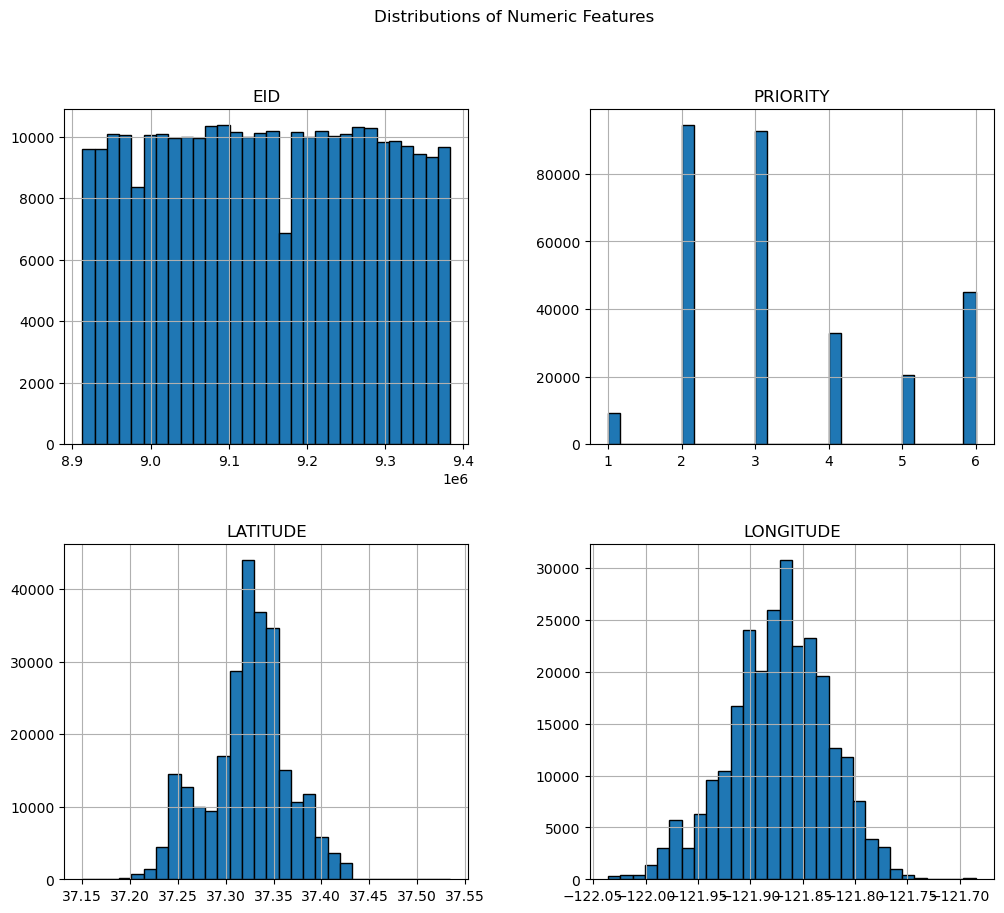

In [11]:
# Plot histograms for numeric columns
all_police_df.hist(figsize=(12, 10), bins=30, edgecolor='black')
plt.suptitle('Distributions of Numeric Features')
plt.show()

In [12]:
missing_data = all_police_df.isnull().sum()
missing_data

CDTS                    0
EID                     0
START_DATE              0
CALL_NUMBER             0
PRIORITY                0
REPORT_DATE             0
OFFENSE_DATE            0
OFFENSE_TIME            0
CALLTYPE_CODE           0
CALL_TYPE               0
FINAL_DISPO_CODE        0
FINAL_DISPO             0
ADDRESS              8849
CITY                    0
STATE                   0
LATITUDE            30572
LONGITUDE           30572
neighborhood        31798
dtype: int64

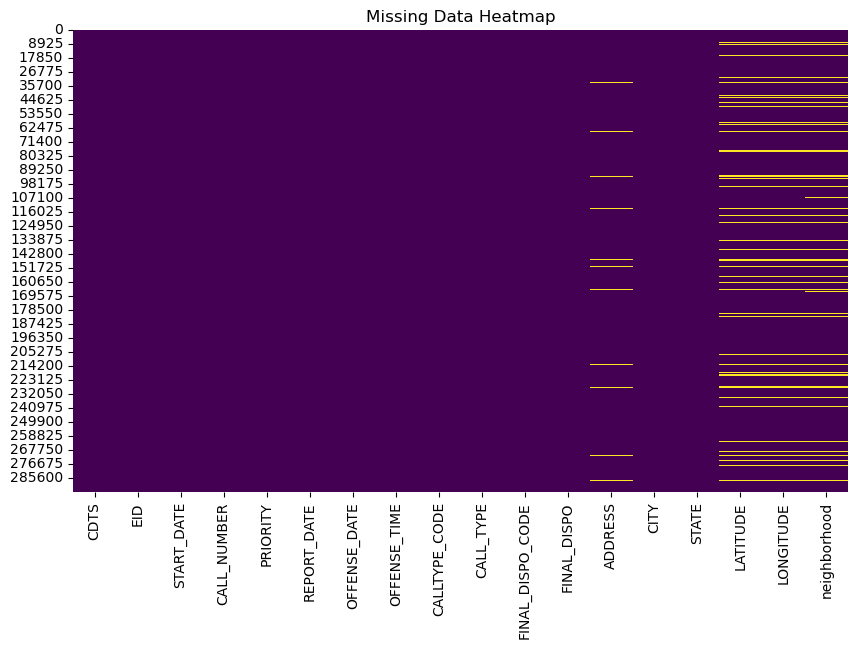

In [14]:
# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(all_police_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [15]:
for column in all_police_df.select_dtypes(include=['object']).columns:
    unique_values = all_police_df[column].nunique()
    print(f'{column}: {unique_values} unique values')

CDTS: 292604 unique values
START_DATE: 339 unique values
CALL_NUMBER: 287596 unique values
REPORT_DATE: 359 unique values
OFFENSE_DATE: 359 unique values
OFFENSE_TIME: 80565 unique values
CALLTYPE_CODE: 206 unique values
CALL_TYPE: 200 unique values
FINAL_DISPO_CODE: 22 unique values
FINAL_DISPO: 18 unique values
ADDRESS: 29750 unique values
CITY: 1 unique values
STATE: 1 unique values
neighborhood: 295 unique values


In [16]:
all_police_df['neighborhood'].value_counts()

neighborhood
Spartan Keyes and Wool Creek      8465
Little Saigon and Spring Brook    4854
Trimble Business Area             4451
Five Wounds-San Jose High         4108
Alameda                           3595
                                  ... 
Los Alamitos Creek                  38
Linda Vista and Hillcrest           34
Meadowlands                         32
Alta Vista                          22
Santa Teresa Hills                  14
Name: count, Length: 295, dtype: int64

In [19]:
all_police_df['FINAL_DISPO_CODE'].value_counts()

FINAL_DISPO_CODE
N          138290
CAN         52022
R           33213
G           14722
D            9999
E            6254
O            5798
GD           5326
DUPNCAN      4931
A            4435
U            3956
H            3056
T            2787
ADV          2696
C            2270
B            2091
NR           1813
F             723
Z              51
M              38
P              35
TOT             9
Name: count, dtype: int64

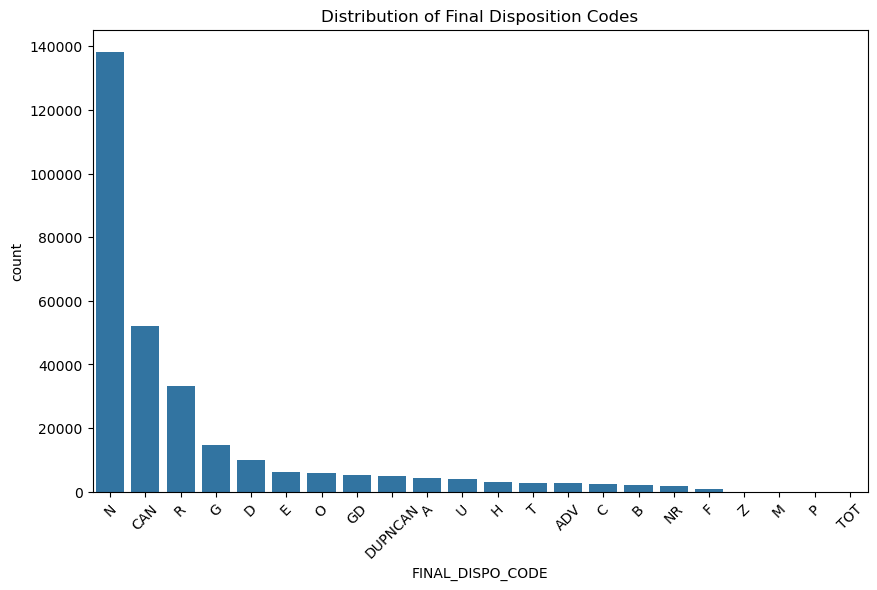

In [22]:
# Bar plot for target variable (FINAL_DISPO_CODE)
plt.figure(figsize=(10, 6))
sns.countplot(data=all_police_df, x='FINAL_DISPO_CODE', order=all_police_df['FINAL_DISPO_CODE'].value_counts().index)
plt.title('Distribution of Final Disposition Codes')
plt.xticks(rotation=45)
plt.show()

In [23]:
all_police_df['FINAL_DISPO'].value_counts()

FINAL_DISPO
No report required; dispatch record only            138290
Canceled                                             52022
Report taken                                         33213
Gone on Arrival/unable to locate                     14722
No Disposition                                       13013
Traffic Citation Issued, Hazardous Violation          9999
Traffic Citation Issued, Non-Hazardous Violation      6254
Supplemental report taken                             5798
Arrest Made                                           4435
Unfounded event                                       3956
Courtesy Service/Citizen or agency assist             3056
Turned over To (TOT)                                  2787
Criminal Citation                                     2270
Arrest by Warrant                                     2091
No Response                                           1813
Field Interview (F.I.) Completed                       723
Stranded motorist assist                    

In [25]:
# Create a mapping between FINAL_DISPO_CODE and FINAL_DISPO
final_dispo_mapping = dict(zip(all_police_df['FINAL_DISPO_CODE'], all_police_df['FINAL_DISPO']))
final_dispo_mapping

{'N': 'No report required; dispatch record only',
 'CAN': 'Canceled',
 'A': 'Arrest Made',
 'GD': 'No Disposition',
 'T': 'Turned over To (TOT)',
 'NR': 'No Response',
 'G': 'Gone on Arrival/unable to locate',
 'R': 'Report taken',
 'DUPNCAN': 'No Disposition',
 'D': 'Traffic Citation Issued, Hazardous Violation',
 'U': 'Unfounded event',
 'H': 'Courtesy Service/Citizen or agency assist',
 'E': 'Traffic Citation Issued, Non-Hazardous Violation',
 'O': 'Supplemental report taken',
 'B': 'Arrest by Warrant',
 'ADV': 'No Disposition',
 'F': 'Field Interview (F.I.) Completed',
 'C': 'Criminal Citation',
 'P': 'Prior case, follow-up activity only',
 'M': 'Stranded motorist assist',
 'Z': 'No Disposition',
 'TOT': 'No Disposition'}

In [26]:
call_type_code_mapping = dict(zip(all_police_df['CALLTYPE_CODE'], all_police_df['CALL_TYPE']))
call_type_code_mapping

{'1066': 'SUSPICIOUS PERSON',
 '415': 'DISTURBANCE',
 '911UNK': 'UNK TYPE 911 CALL',
 'SUSCIR': 'SUSPICIOUS CIRCUMSTANCES',
 '11300': 'NARCOTICS',
 '415FC': 'DISTURBANCE, FIRECRACKERS',
 '1057': 'FIREARMS DISCHARGED',
 '1095': 'PEDESTRIAN STOP',
 'WELCKEMS': 'WELFARE CHECK (COMBINED EVENT)',
 'AID': 'PUBLIC SAFETY ASSISTANCE',
 '1033A': 'ALARM, AUDIBLE',
 '415M': 'DISTURBANCE, MUSIC',
 '1070': 'PROWLER',
 'WELCK': 'WELFARE CHECK',
 '1033S': 'ALARM, SILENT',
 '23103': 'RECKLESS DRIVING',
 '1066W': 'SUSPICIOUS PERSON W/ WEAPON',
 '5150': 'MENTALLY DISTURBED PERSON',
 '242': 'BATTERY',
 '417': 'BRANDISHING A WEAPON',
 '22500': 'PARKING VIOLATION',
 '1195': 'VEHICLE STOP',
 '1154': 'SUSPICIOUS VEHICLE',
 '415F': 'DISTURBANCE, FAMILY',
 '20002': 'MISDEMEANOR HIT AND RUN',
 '484': 'THEFT',
 '415A': 'DISTURBANCE, FIGHT',
 '10851': 'STOLEN VEHICLE',
 '1182': 'VEHICLE ACCIDENT, PROPERTY DAMAGE',
 '10851R': 'RECOVERED STOLEN VEHICLE',
 '12025': 'CARRYING A CONCEALED WEAPON',
 'FNDPRP': 'FOUND PR

## Focus on Target Dispositions

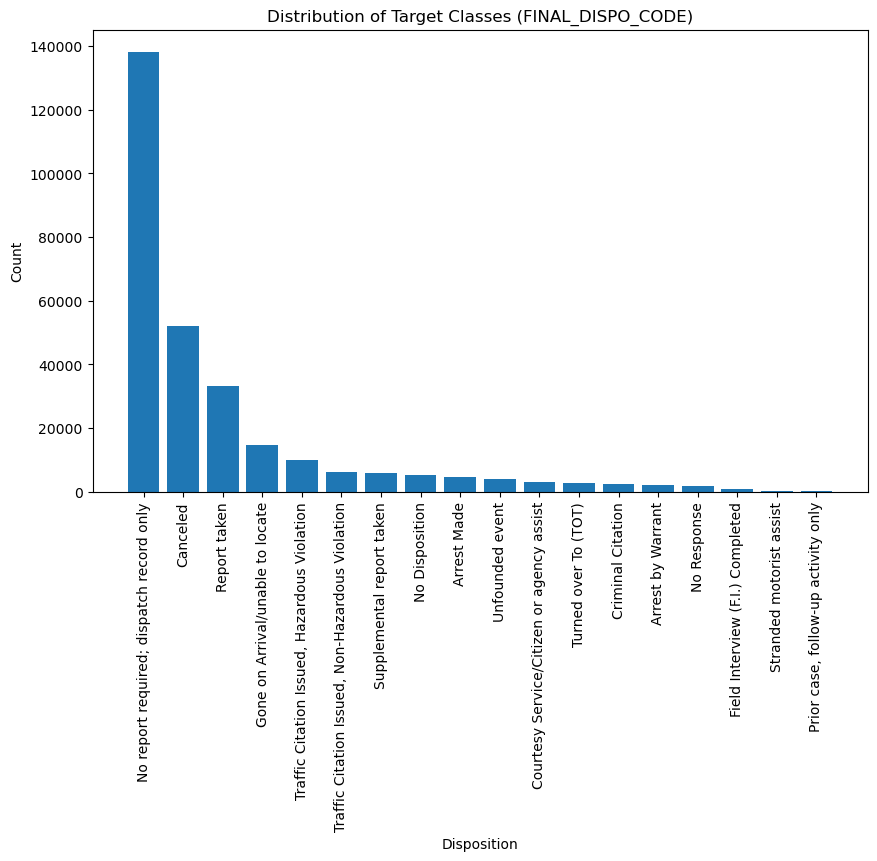

In [30]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['FINAL_DISPO_CODE'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [final_dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (FINAL_DISPO_CODE)')
plt.xlabel('Disposition')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

In [31]:
model_utils.transform_offense_date(all_police_df)

In [32]:
dispo_mapping = model_utils.calc_dispo_subset(all_police_df)
all_police_df['DISPO_SUBSET'].value_counts()

DISPO_SUBSET
Other    285719
A          4435
C          2270
B          2091
Name: count, dtype: int64

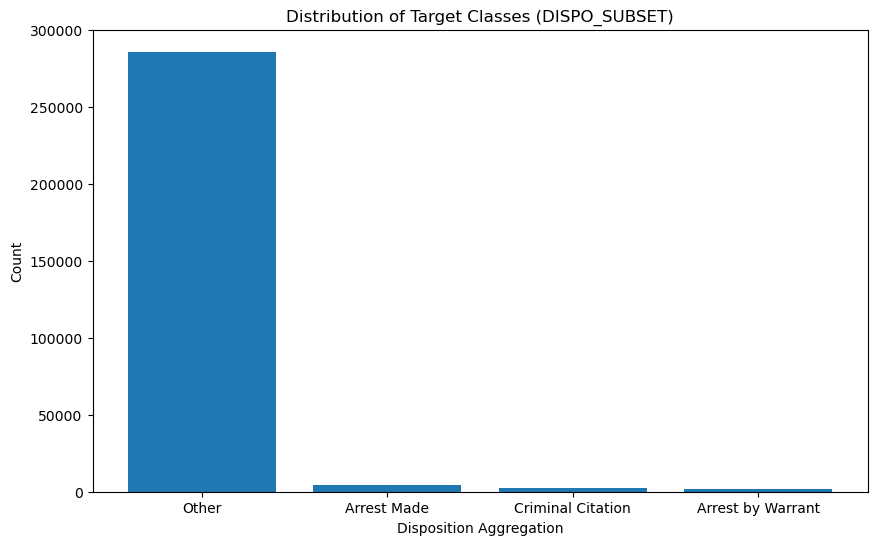

In [33]:
# Get the value counts of the DISPO_SUBSET column
dispo_counts = all_police_df['DISPO_SUBSET'].value_counts()

# Create a list of names using the dispo_mapping
dispo_names = [dispo_mapping[code] for code in dispo_counts.index]

# Plot the distribution of target classes with disposition names
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(dispo_names, dispo_counts.values)
plt.title('Distribution of Target Classes (DISPO_SUBSET)')
plt.xlabel('Disposition Aggregation')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.savefig('images/class_imbalance.png')
plt.show()

## Data Cleaning and Feature Engineering

In [35]:
police_calls_encoded = model_utils.clean_and_transform_data(all_police_df)

Police Calls Dataset: 294515 rows before cleaning, 262717 rows after cleaning.


In [36]:
police_calls_encoded.shape

(262717, 15)

In [37]:
police_calls_encoded

,PRIORITY,CALLTYPE_CODE,LATITUDE,LONGITUDE,neighborhood,OFFENSE_HOUR,OFFENSE_DAY_OF_WEEK,OFFENSE_MONTH,OFFENSE_YEAR,AFTER_COVID,DISPO_SUBSET,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2
0,2,1066,0.278048,0.221421,Olinder-McKinley,0,5,1,2022,Yes,Other,0.024956,0.077311,0.061566,0.049027
2,2,911UNK,-1.250703,-2.449672,Forest Hill/Westmont,0,5,1,2022,Yes,Other,0.121931,1.564259,3.063813,6.000892
3,2,SUSCIR,-0.118783,-1.955743,Cypress,0,5,1,2022,Yes,Other,0.080501,0.014109,0.232308,3.824931
4,4,11300,-0.078443,1.352242,Thompson Creek,0,5,1,2022,Yes,A,0.080220,0.006153,-0.106074,1.828557
5,4,415FC,-1.642224,0.050064,Foxchase and Oakridge,0,5,1,2022,Yes,Other,0.086076,2.696899,-0.082217,0.002506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294508,3,1033A,-2.843985,0.263370,Williams,0,5,12,2022,Yes,Other,0.137922,8.088248,-0.749021,0.069364
294509,1,415W,0.044000,1.203196,Meadow Fair,0,5,12,2022,Yes,Other,0.072274,0.001936,0.052940,1.447681
294511,3,1125,-0.979226,0.932707,Seven Trees and Lairon,0,5,12,2022,Yes,Other,0.081120,0.958884,-0.913331,0.869943
294512,3,1033A,-0.073849,0.298608,Little Saigon and Spring Brook,0,5,12,2022,Yes,Other,0.033658,0.005454,-0.022052,0.089167


## Define X and Y

In [40]:
# load the encoder file
encoder = joblib.load('one_hot_encoder.pkl')

In [44]:
X_train, X_test, y_train, y_test, label_names, class_labels, X_train_resampled, y_train_resampled, _ = \
    model_utils.split_data(police_calls_encoded, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(210173, 14)
(52544, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']
Counter({3: 203759, 0: 3254, 2: 1622, 1: 1538})
Counter({3: 6414, 0: 3254, 2: 1622, 1: 1538})


In [45]:
X_train.shape

(210173, 529)

In [48]:
X_train

,PRIORITY,LATITUDE,LONGITUDE,DISTANCE_FROM_CENTER,LATITUDE^2,LATITUDE LONGITUDE,LONGITUDE^2,CALLTYPE_CODE_1033,CALLTYPE_CODE_1033A,CALLTYPE_CODE_1033CTX,...,neighborhood_Willow Glen South,neighborhood_Willow Glen West,neighborhood_Willow Vale,neighborhood_Willowmont,neighborhood_Winchester,neighborhood_Winchester Lynnhaven,neighborhood_Windmill Springs,neighborhood_Wooster and East Ct and West Ct,neighborhood_YB Lucretia,AFTER_COVID_Yes
866,-1.605416,0.326323,-0.427333,-1.525963,-0.639724,0.029652,-0.564572,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
167751,1.855650,0.108827,1.900162,1.389532,-0.707349,0.337792,1.802783,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
234564,-0.220990,-1.293776,0.313887,0.535700,0.483023,-0.207697,-0.623208,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45658,1.855650,-0.947099,0.897661,0.636583,-0.073215,-0.604142,-0.134845,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
234467,-0.913203,1.524900,0.303245,-0.007059,0.947797,0.565692,-0.627739,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,-0.220990,0.064193,1.132084,0.333946,-0.712852,0.218445,0.193816,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
185253,-0.220990,0.615227,-0.589850,-1.184888,-0.445178,-0.169725,-0.450216,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
154658,-0.913203,0.263804,-0.013598,-1.283643,-0.666097,0.150722,-0.690936,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
163963,-0.220990,0.185887,-0.820883,-0.949614,-0.691135,0.018125,-0.224814,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


y_train distribution: Counter({3: 203759, 0: 3254, 2: 1622, 1: 1538})
y_test distribution: Counter({3: 50941, 0: 813, 2: 406, 1: 384})
y_train_resampled distribution: Counter({3: 203759, 0: 3254, 2: 1622, 1: 1538})


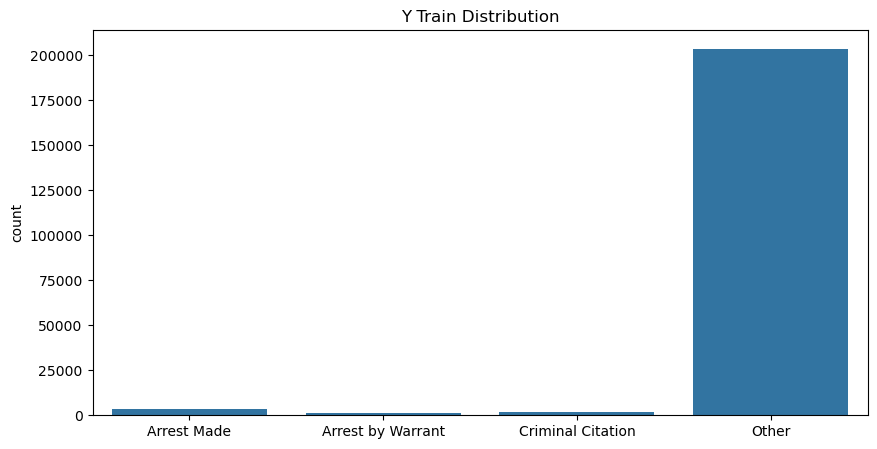

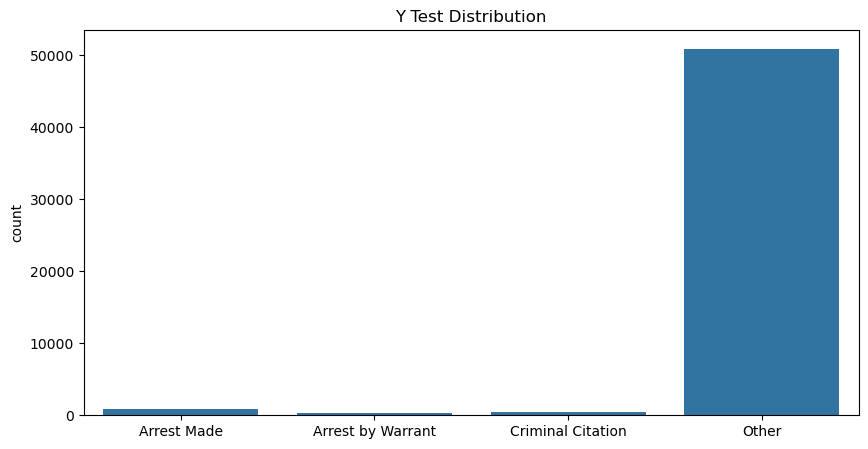

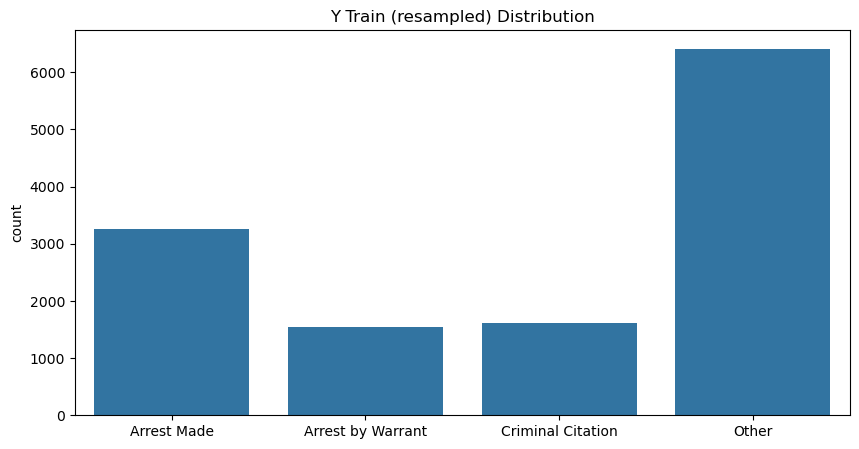

In [51]:
# Count the occurrences of each class in y_train and y_test
train_counts = collections.Counter(y_train)
test_counts = collections.Counter(y_test)

print("y_train distribution:", train_counts)
print("y_test distribution:", test_counts)

train_resampled_counts = collections.Counter(y_train_resampled)

print("y_train_resampled distribution:", train_counts)

# Bar plot for y_train
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train Distribution')
plt.show()

# Bar plot for y_test
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_test)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Test Distribution')
plt.show()

# Bar plot for y_train_resampled
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_train_resampled)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_labels)
plt.title('Y Train (resampled) Distribution')
plt.show()

## Evaluate Different Baseline Models

### Most Frequent Class Model

In [62]:
# Step 1: Find the most frequent class in the training set
most_frequent_class = np.bincount(y_train).argmax()

In [63]:
# Step 2: Predict the most frequent class for all samples in the test set
y_pred_baseline = [most_frequent_class] * len(y_test)

In [64]:
# Step 3: Evaluate the baseline model
print("Baseline Model (Most Frequent Class) Classification Report:")
print(classification_report(y_test, y_pred_baseline, zero_division=0, target_names=label_names))

Baseline Model (Most Frequent Class) Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.00      0.00      0.00       813
Arrest by Warrant       0.00      0.00      0.00       384
Criminal Citation       0.00      0.00      0.00       406
            Other       0.97      1.00      0.98     50941

         accuracy                           0.97     52544
        macro avg       0.24      0.25      0.25     52544
     weighted avg       0.94      0.97      0.95     52544



### Logistic Regression

In [69]:
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=1000, random_state=42)

In [70]:
y_pred_lr = lr_model.predict(X_test)
print("DONE")

DONE


In [72]:
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0, target_names=label_names))

Logistic Regression Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.12      0.59      0.20       813
Arrest by Warrant       0.33      0.58      0.42       384
Criminal Citation       0.13      0.43      0.20       406
            Other       0.99      0.90      0.94     50941

         accuracy                           0.89     52544
        macro avg       0.39      0.63      0.44     52544
     weighted avg       0.96      0.89      0.92     52544



#### Hyperparameter Tuning

In [77]:
grid_search_scoring_method = 'f1_macro'

In [78]:
# Define parameter grid
param_grid_lr = {
    'C': [0.1, 1, 10]
}

grid_lr = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42), param_grid=param_grid_lr, 
                              cv=5, n_jobs=2, verbose=1, scoring=grid_search_scoring_method)

grid_lr.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=2, param_grid={'C': [0.1, 1, 10]}, scoring='f1_macro',
             verbose=1)

In [79]:
# Best parameters and score
print(f"Best Parameters: {grid_lr.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_lr.best_score_:.4f}")

Best Parameters: {'C': 10}
Best Score (f1_macro): 0.5321


In [80]:
# Use the best estimator to make predictions
best_lr = grid_lr.best_estimator_

# save
joblib.dump(best_lr, f"models/{year}/best_logistic_regression.pkl") 

['models/2022/best_logistic_regression.pkl']

In [81]:
# load
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")

In [82]:
y_pred_best_lr = best_lr.predict(X_test)

# Evaluate the best model
print("Best Logistic Regression Classification Report for Police Calls:")
print(classification_report(y_test, y_pred_best_lr, zero_division=0, target_names=label_names))

Best Logistic Regression Classification Report for Police Calls:
                   precision    recall  f1-score   support

      Arrest Made       0.58      0.24      0.34       813
Arrest by Warrant       0.66      0.51      0.57       384
Criminal Citation       0.47      0.24      0.32       406
            Other       0.98      0.99      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.67      0.50      0.55     52544
     weighted avg       0.97      0.97      0.97     52544



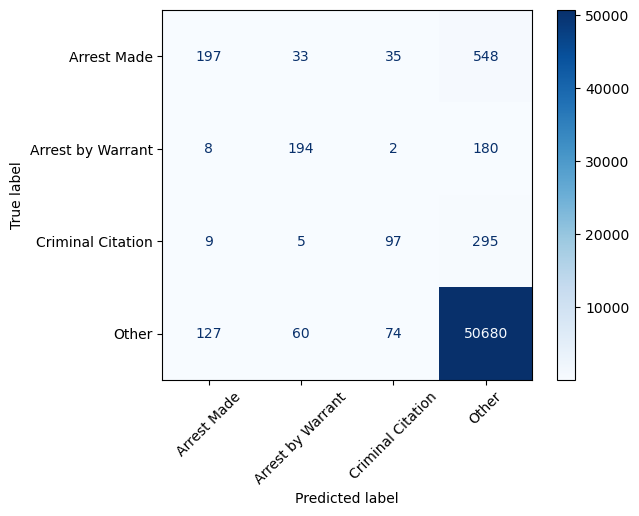

In [83]:
ConfusionMatrixDisplay.from_estimator(best_lr, X_test, y_test, display_labels=label_names, xticks_rotation=45, cmap=plt.cm.Blues)

#### Feature Importance

In [85]:
from sklearn.inspection import permutation_importance

# Calculate permutation feature importance on sample data to speed things up

# Sample 20% of X_test and y_test
sample_size = int(0.2 * len(X_test))
X_test_sample = X_test.sample(sample_size, random_state=42)

# Get the positional indices from the sample, and use them to index the numpy array y_test
pos_indices = X_test.index.get_indexer(X_test_sample.index)
y_test_sample = y_test[pos_indices]

permutation_importance_result = permutation_importance(best_lr, X_test_sample, y_test_sample, n_repeats=3, random_state=42)

In [88]:
# Create a DataFrame to store the feature importance results
importance_df = pd.DataFrame({
    'feature': X_test_sample.columns,
    'importance_mean': permutation_importance_result.importances_mean
})

# Define a mapping of one-hot encoded columns to their original categorical feature
# This is a dictionary where keys are the original feature names, and values are lists of one-hot encoded columns
one_hot_mapping = {
    'CALLTYPE_CODE': [col for col in X_test_sample.columns if col.startswith("CALLTYPE_CODE_")],
    'neighborhood': [col for col in X_test_sample.columns if col.startswith("neighborhood_")]
}

# Initialize a list to store aggregated and non-one-hot encoded features
final_importance = []

# 1. Aggregate the importance for one-hot encoded features
for original_feature, encoded_columns in one_hot_mapping.items():
    # Sum the importance of the one-hot encoded columns for this feature
    aggregated_importance = importance_df.loc[importance_df['feature'].isin(encoded_columns), 'importance_mean'].sum()
    final_importance.append({
        'feature': original_feature,
        'importance_mean': aggregated_importance
    })

# 2. Add the importance of the non-one-hot encoded features
# Find columns that are not part of the one-hot encoded mappings
all_one_hot_encoded_columns = [col for sublist in one_hot_mapping.values() for col in sublist]
non_one_hot_encoded_features = importance_df.loc[~importance_df['feature'].isin(all_one_hot_encoded_columns)]

# Append non-one-hot encoded features' importance to the final list
for _, row in non_one_hot_encoded_features.iterrows():
    final_importance.append({
        'feature': row['feature'],
        'importance_mean': row['importance_mean']
    })

# Convert final importance list to a DataFrame
final_importance_df = pd.DataFrame(final_importance)

# Sort by importance for easier interpretation
final_importance_df = final_importance_df.sort_values(by='importance_mean', ascending=False)

In [91]:
# Use display to see the dataframe nicely formatted
from IPython.display import display
display(final_importance_df)

,feature,importance_mean
0,CALLTYPE_CODE,0.015322
8,LONGITUDE^2,0.001110
1,neighborhood,0.001079
6,LATITUDE^2,0.000888
2,PRIORITY,0.000698
5,DISTANCE_FROM_CENTER,0.000666
3,LATITUDE,0.000159
4,LONGITUDE,0.000127
9,AFTER_COVID_Yes,0.000000
7,LATITUDE LONGITUDE,-0.000063


In [92]:
# Set maximum number of rows to display
pd.set_option('display.max_rows', 200)

In [93]:
feature_names = X_train.columns

call_types = []
for feature_name in feature_names:
    if feature_name.startswith("CALLTYPE_CODE_"):
        code = feature_name[14:]
        call_type = call_type_code_mapping.get(code, '')
        call_types.append(call_type)
    else:
        call_types.append("")

# Create a DataFrame of the results
perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': permutation_importance_result.importances_mean,
    'Call Type': call_types
})

# Sort by importance and display the top features
top_perm_features = perm_importance_df.sort_values(by='Importance', ascending=False).head(100)
print(top_perm_features)

                                         Feature  Importance  \
200                             CALLTYPE_CODE_6M    0.004631   
199                             CALLTYPE_CODE_6F    0.002252   
59                           CALLTYPE_CODE_11300    0.001523   
6                                    LONGITUDE^2    0.001110   
4                                     LATITUDE^2    0.000888   
0                                       PRIORITY    0.000698   
107                          CALLTYPE_CODE_23152    0.000698   
3                           DISTANCE_FROM_CENTER    0.000666   
67                           CALLTYPE_CODE_11550    0.000666   
80                           CALLTYPE_CODE_12020    0.000444   
82                           CALLTYPE_CODE_12025    0.000444   
64                           CALLTYPE_CODE_11377    0.000381   
8                            CALLTYPE_CODE_1033A    0.000349   
86                             CALLTYPE_CODE_148    0.000349   
61                           CALLTYPE_CO

In [94]:
for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })
    
    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(50)
    
    # Display the top most important features
    print(f"\nlabel = {label_names[index]}")
    print(top_features[['Display Name', 'Coefficient']])


label = Arrest Made
                                       Display Name  Coefficient
107                      Call Type: MISDEMEANOR DUI     3.198645
108                           Call Type: FELONY DUI     3.069014
118           Call Type: BATTERY ON A PEACE OFFICER     2.896330
82           Call Type: CARRYING A CONCEALED WEAPON     2.536596
225        Call Type: VIOLATION OF PROTECTIVE ORDER     2.526241
87        Call Type: RESISTING ARREST, GANG RELATED     2.511694
129         Call Type: REGISTRATION OF SEX OFFENDER     2.510738
81         Call Type: ILLEGAL WEAPONS, GANG RELATED     2.411693
206                    Call Type: UNK TYPE 911 CALL    -2.385437
102                    Call Type: PARKING VIOLATION    -2.341475
33           Call Type: SUSPICIOUS PERSON W/ WEAPON    -2.287370
131                     Call Type: PAROLE VIOLATION     2.216111
83                     Call Type: UNLICENSED DRIVER    -2.177438
213          Call Type: CARRYING A CONCEALED WEAPON     2.175764
86  

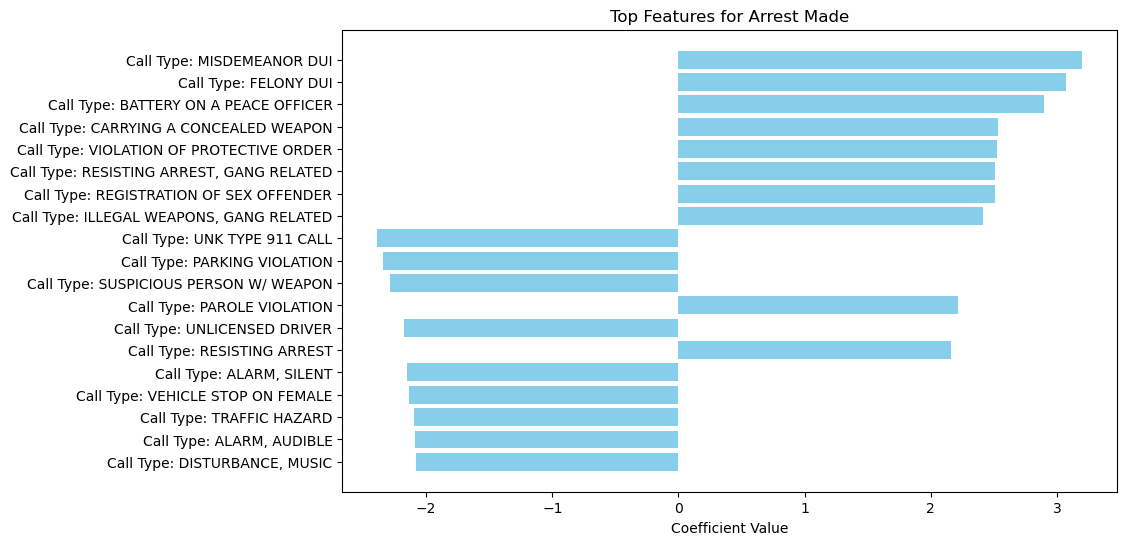

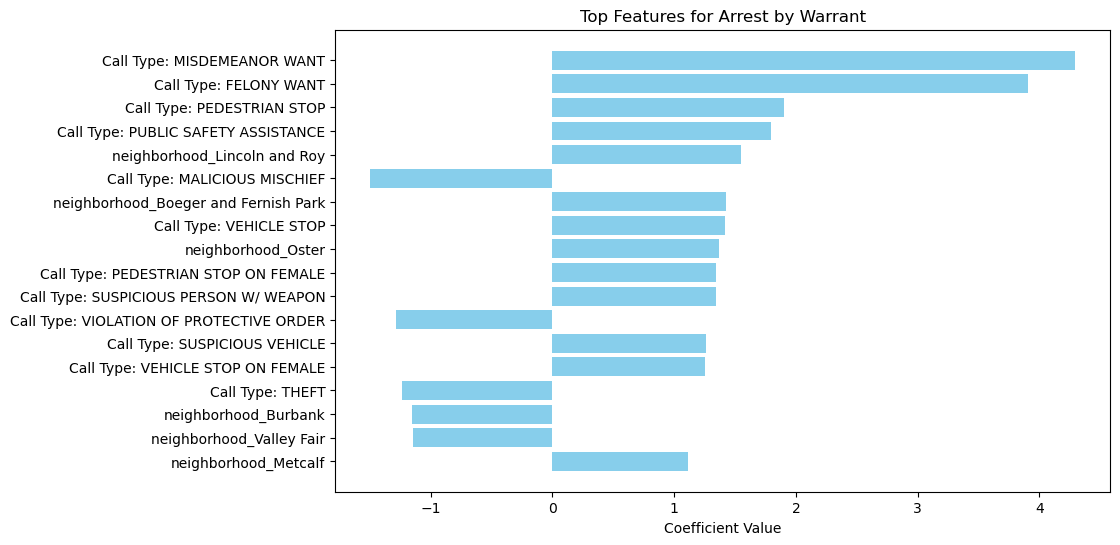

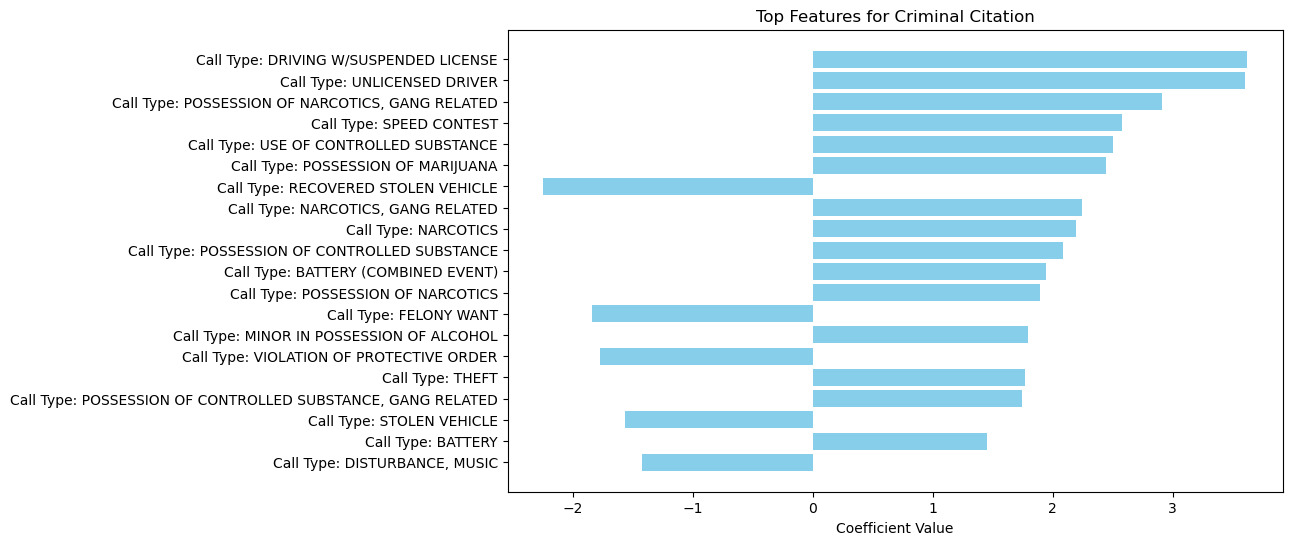

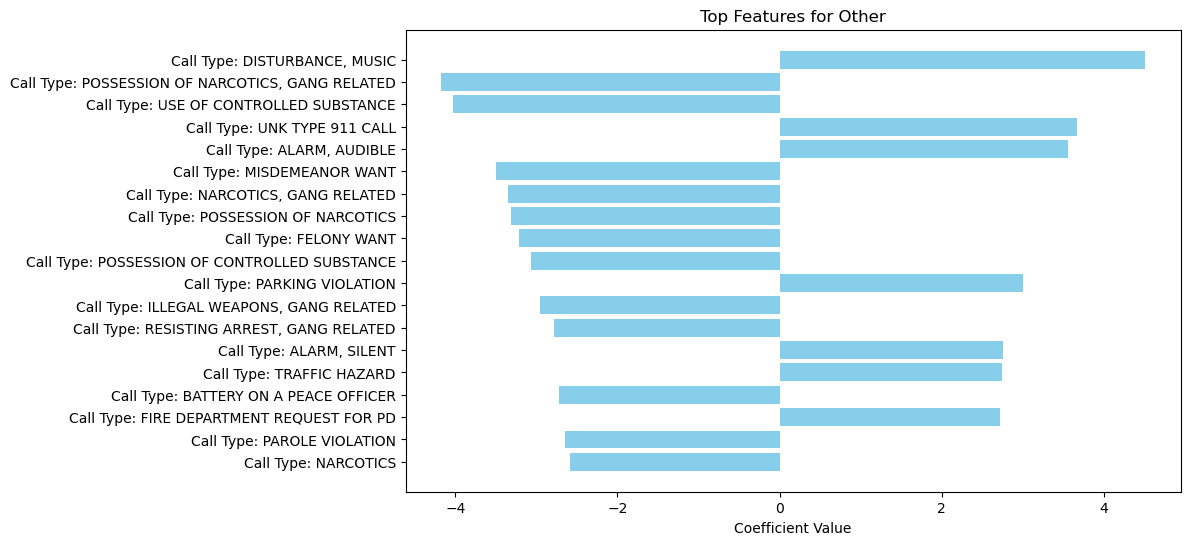

In [95]:
import matplotlib.pyplot as plt

for index, coefficients in enumerate(best_lr.coef_):
    
    # Create a DataFrame of feature names and their corresponding coefficients
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Call Type': call_types
    })

    # Create a column that uses 'Call Type' if available, otherwise uses 'Feature'
    coef_df['Display Name'] = np.where(coef_df['Call Type'], "Call Type: " + coef_df['Call Type'], coef_df['Feature'])
    
    # Sort by the absolute value of the coefficients
    coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
    top_features = coef_df.sort_values(by='Abs_Coefficient', ascending=False).head(20)
    
    # Plot the top coefficients as a bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['Display Name'], top_features['Coefficient'], color='skyblue')
    plt.xlabel('Coefficient Value')
    plt.title(f'Top Features for {label_names[index]}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient at the top
    plt.show()


### Random Forest

In [97]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [98]:
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0, target_names=label_names))

Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.49      0.27      0.35       813
Arrest by Warrant       0.58      0.41      0.48       384
Criminal Citation       0.39      0.20      0.26       406
            Other       0.98      0.99      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.61      0.47      0.52     52544
     weighted avg       0.96      0.97      0.97     52544



#### Hyperparameter Tuning and Cross Validation

In [100]:
# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 60],
}

# Initialize Grid Search
grid_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, n_jobs=-1,
                              cv=5, verbose=1, scoring=grid_search_scoring_method)

# Fit Grid Search
grid_rf.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_rf.best_params_}")
print(f"Best Score ({grid_search_scoring_method}): {grid_rf.best_score_:.2f}")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best Parameters: {'n_estimators': 50}
Best Score (f1_macro): 0.50


In [101]:
best_rf = grid_rf.best_estimator_

In [102]:
# save
joblib.dump(best_rf, f"models/{year}/best_random_forest.pkl") 

['models/2022/best_random_forest.pkl']

In [103]:
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")

In [104]:
# Use the best estimator to make predictions
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.48      0.26      0.34       813
Arrest by Warrant       0.58      0.41      0.48       384
Criminal Citation       0.37      0.20      0.26       406
            Other       0.98      0.99      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.60      0.47      0.52     52544
     weighted avg       0.96      0.97      0.97     52544



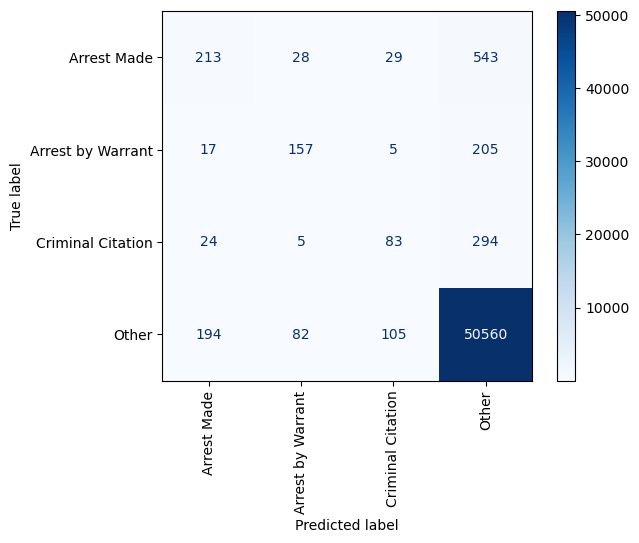

In [105]:
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)

plt.show()

In [106]:
#### Optuna

def rf_objective(trial):
    # Suggest values for the hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    max_depth = trial.suggest_int('max_depth', 5, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])

    # Initialize RandomForest with suggested hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    # Use cross-validation to evaluate the model
    score = cross_val_score(clf, X_train_resampled, y_train_resampled, cv=5, scoring='f1_macro').mean()
    return score

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(rf_objective, n_trials=20)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-10-08 13:51:08,790] A new study created in memory with name: no-name-1fb0f572-bbbd-448b-9c70-69a7dd8f1a0b
[I 2024-10-08 13:51:10,283] Trial 0 finished with value: 0.60574402354865 and parameters: {'n_estimators': 56, 'max_depth': 74, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.60574402354865.
[I 2024-10-08 13:51:11,015] Trial 1 finished with value: 0.5943758581961991 and parameters: {'n_estimators': 60, 'max_depth': 76, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: 0.60574402354865.
[I 2024-10-08 13:51:12,110] Trial 2 finished with value: 0.6318147039565567 and parameters: {'n_estimators': 80, 'max_depth': 53, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.6318147039565567.
[I 2024-10-08 13:51:12,841] Trial 3 finished with value: 0.1666666644149098 and parameters: {'n_estimators': 96, 'max_depth': 7, 'min_samples_

Best hyperparameters: {'n_estimators': 89, 'max_depth': 84, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


In [107]:
best_params = study.best_params
best_params

{'n_estimators': 89,
 'max_depth': 84,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_features': 'sqrt'}

In [108]:
# Train the RandomForest using the best hyperparameters
best_rf_2 = RandomForestClassifier(**best_params, n_jobs=-1)
best_rf_2.fit(X_train, y_train)

RandomForestClassifier(max_depth=84, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=89, n_jobs=-1)

In [109]:
# Use the best estimator to make predictions
y_pred_best_rf_2 = best_rf_2.predict(X_test)

# Evaluate the best model
print("Best Random Forest Classification Report:")
print(classification_report(y_test, y_pred_best_rf_2, zero_division=0, target_names=label_names))

Best Random Forest Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.66      0.23      0.35       813
Arrest by Warrant       0.66      0.53      0.59       384
Criminal Citation       0.51      0.17      0.25       406
            Other       0.98      1.00      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.70      0.48      0.54     52544
     weighted avg       0.97      0.97      0.97     52544



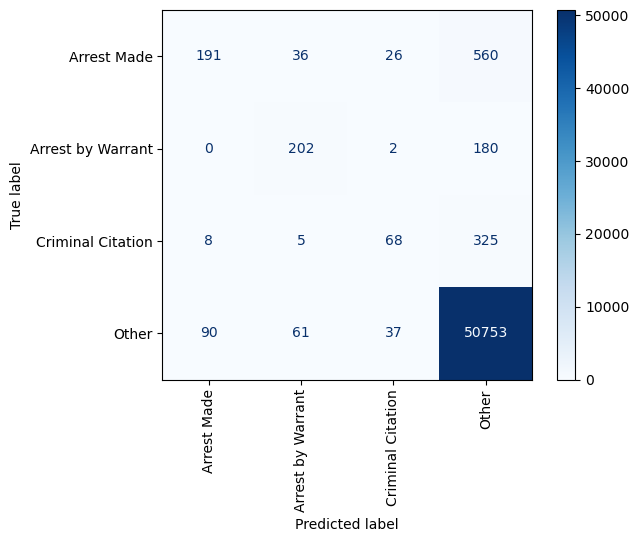

In [110]:
ConfusionMatrixDisplay.from_estimator(best_rf_2, X_test, y_test, display_labels=label_names, xticks_rotation=90, cmap=plt.cm.Blues)
plt.show()

#### Feature Importance

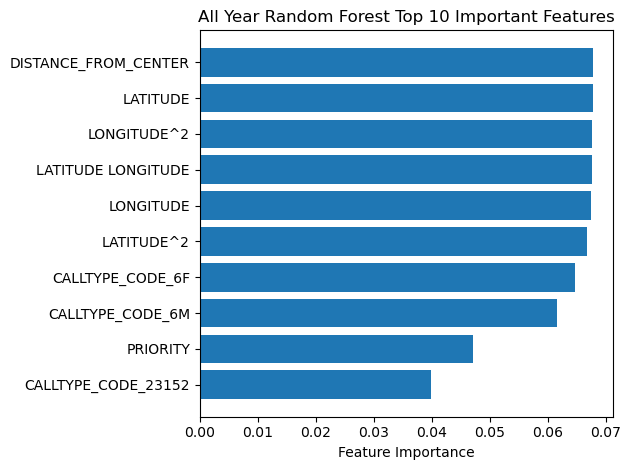

In [112]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances and sort them in descending order
importances = best_rf.feature_importances_
indices = np.argsort(importances)[-10:]  # Select top 10 features

# Create a bar chart for the top 10 features
plt.barh(np.array(feature_names)[indices], importances[indices])
plt.xlabel('Feature Importance')
plt.title('All Year Random Forest Top 10 Important Features')
plt.tight_layout()  # Adjusts the padding automatically
plt.savefig('images/all_year_random_forest_feature_importance.png')
plt.show()

### Multilayer Perceptron Model

In [114]:
# Set up early stopping and model checkpoint callbacks so we choose the best model

# Define the callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=3,          # stop training if val_loss doesn't improve for N epochs
    restore_best_weights=True  # restore model to the epoch with the best val_loss
)

# Save the best model
model_checkpoint = ModelCheckpoint(
    'best_model.mcp.keras',    # path to save the best model
    monitor='val_loss', # monitor validation loss
    save_best_only=True # only save the model with the best val_loss
)

In [115]:
# Build the MLP model
mlp_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(y_train)), activation='softmax')
])

mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [116]:
# Train the model
history = mlp_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, 
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9684 - loss: 0.1591 - val_accuracy: 0.9728 - val_loss: 0.1074
Epoch 2/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9736 - loss: 0.1092 - val_accuracy: 0.9732 - val_loss: 0.1078
Epoch 3/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9741 - loss: 0.1063 - val_accuracy: 0.9744 - val_loss: 0.1069
Epoch 4/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9749 - loss: 0.1029 - val_accuracy: 0.9741 - val_loss: 0.1090
Epoch 5/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9751 - loss: 0.0980 - val_accuracy: 0.9736 - val_loss: 0.1097
Epoch 6/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9754 - loss: 0.0960 - val_accuracy: 0.9736 - val_loss: 0.1101


In [117]:
# save
joblib.dump(mlp_model, f"models/{year}/mlp_model.pkl") 

['models/2022/mlp_model.pkl']

In [118]:
mlp_model = joblib.load(f"models/{year}/mlp_model.pkl")

In [119]:
# Evaluate on test data
test_loss, test_acc = mlp_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.4f}')

1642/1642 ━━━━━━━━━━━━━━━━━━━━ 1s 503us/step - accuracy: 0.9741 - loss: 0.1091
Test Accuracy: 0.9743


In [120]:
# Make predictions
y_pred_nn = mlp_model.predict(X_test)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Classification report
print("Multilayer Perceptron Classification Report:")
print(classification_report(y_test, y_pred_nn_classes, zero_division=0, target_names=label_names))

1642/1642 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step
Multilayer Perceptron Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.62      0.26      0.37       813
Arrest by Warrant       0.66      0.52      0.58       384
Criminal Citation       0.48      0.24      0.32       406
            Other       0.98      1.00      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.68      0.50      0.56     52544
     weighted avg       0.97      0.97      0.97     52544



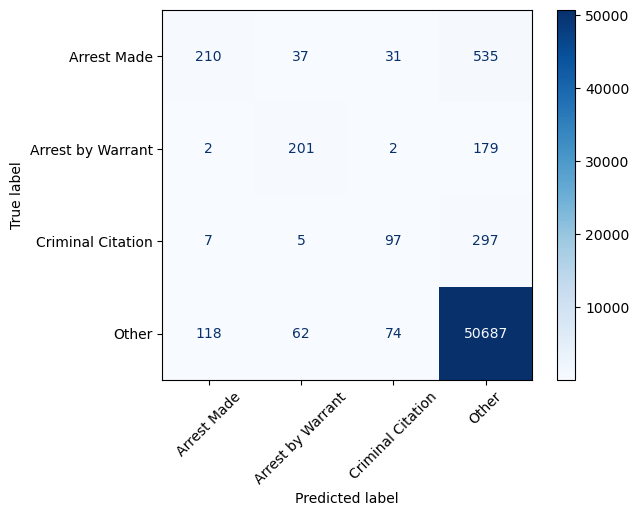

In [121]:
cm = confusion_matrix(y_test, y_pred_nn_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.show()

### XGBoost

In [124]:
def objective(trial):
    params = {
        'n_estimators': 300,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }
    
    xgb_clf = XGBClassifier(**params, eval_metric='logloss')
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    try:
        scores = cross_val_score(xgb_clf, X_train_resampled, y_train_resampled, scoring='f1_macro', cv=cv, n_jobs=1)
        return np.mean(scores)
    except Exception as e:
        print(f"An error occurred: {e}")
        return float('-inf')

# Create a study object and specify the direction is 'maximize' for f1_macro score
study = optuna.create_study(direction='maximize')

# Number of trials
n_trials = 20

# Optimize the study
start_time = time.time()
study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
end_time = time.time()

actual_runtime = end_time - start_time
print(f"Actual runtime: {actual_runtime:.2f} seconds ({actual_runtime/60:.2f} minutes)")

# Print the best parameters and score
print("Best parameters found: ", study.best_params)
print("Best F1 macro score: ", study.best_value)

[I 2024-10-08 13:52:28,441] A new study created in memory with name: no-name-374c009d-8733-4337-b5b0-d6cace42ddba
[I 2024-10-08 13:52:43,249] Trial 0 finished with value: 0.6385326073854686 and parameters: {'learning_rate': 0.17493330012626768, 'max_depth': 5, 'subsample': 0.6881392910684166, 'colsample_bytree': 0.9730780704148372, 'gamma': 0.00010300653018405784, 'reg_alpha': 7.097515403269567e-07, 'reg_lambda': 2.6345251794523107e-05}. Best is trial 0 with value: 0.6385326073854686.
[I 2024-10-08 13:52:54,805] Trial 1 finished with value: 0.6488061261587801 and parameters: {'learning_rate': 0.1297493223656944, 'max_depth': 3, 'subsample': 0.8366965174552032, 'colsample_bytree': 0.6762261366521861, 'gamma': 4.5486231163382146e-08, 'reg_alpha': 0.006490900422852567, 'reg_lambda': 1.5184553708177962e-08}. Best is trial 1 with value: 0.6488061261587801.
[I 2024-10-08 13:53:09,956] Trial 2 finished with value: 0.5429668686313959 and parameters: {'learning_rate': 0.005288248419896874, 'max

Actual runtime: 365.38 seconds (6.09 minutes)
Best parameters found:  {'learning_rate': 0.1297493223656944, 'max_depth': 3, 'subsample': 0.8366965174552032, 'colsample_bytree': 0.6762261366521861, 'gamma': 4.5486231163382146e-08, 'reg_alpha': 0.006490900422852567, 'reg_lambda': 1.5184553708177962e-08}
Best F1 macro score:  0.6488061261587801


In [125]:
# train the final model with the best parameters:
best_params = study.best_params
xgb_1_model = XGBClassifier(**best_params, eval_metric='logloss')
xgb_1_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6762261366521861, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=4.5486231163382146e-08, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1297493223656944, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [126]:
y_pred_best_xgb = xgb_1_model.predict(X_test)

xgb_1_accuracy = accuracy_score(y_test, y_pred_best_xgb)
xgb_1_recall = recall_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_prec = precision_score(y_test, y_pred_best_xgb, average='macro')
xgb_1_f1 = f1_score(y_test, y_pred_best_xgb, average='macro')

# Evaluate the best model
print("Best XGBoost Classification Report:")
print(classification_report(y_test, y_pred_best_xgb, zero_division=0, target_names=label_names))

Best XGBoost Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.69      0.14      0.23       813
Arrest by Warrant       0.66      0.51      0.58       384
Criminal Citation       0.51      0.11      0.18       406
            Other       0.98      1.00      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.71      0.44      0.49     52544
     weighted avg       0.97      0.97      0.97     52544



In [127]:
best_xg = xgb_1_model
joblib.dump(best_xg, f"models/{year}/xgb_model.pkl") 

['models/2022/xgb_model.pkl']

In [128]:
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

## Ensemble

In [130]:
best_lr = joblib.load(f"models/{year}/best_logistic_regression.pkl")
best_rf = joblib.load(f"models/{year}/best_random_forest.pkl")
best_xg = joblib.load(f"models/{year}/xgb_model.pkl")

In [131]:
print(f'LR F1: {f1_score(y_test, best_lr.predict(X_test), average='macro')}')
print(f'RF F1: {f1_score(y_test, best_rf.predict(X_test), average='macro')}')
print(f'XGB F1: {f1_score(y_test, best_xg.predict(X_test), average='macro')}')

LR F1: 0.5547093244127238
RF F1: 0.5167349407235817
XGB F1: 0.49443814587338925


In [132]:
best_lr

LogisticRegression(C=10, max_iter=1000, random_state=42)

In [133]:
best_rf

RandomForestClassifier(n_estimators=50)

In [134]:
best_xg

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6762261366521861, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=4.5486231163382146e-08, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1297493223656944, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [135]:
estimators = [
    ('lr', best_lr),
    ('rf', best_rf),
    ('xg', best_xg)
]

base_estimators_fitted = [best_lr, best_rf, best_xg]

In [136]:
X_train_float = X_train.astype('float64')

In [137]:
stacking_clf_2 = StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(), n_jobs=2)
stacking_clf_2.fit(X_train_float, y_train)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


StackingClassifier(estimators=[('lr',
                                LogisticRegression(C=10, max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(n_estimators=50)),
                               ('xg',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6762261366521861,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              e...
                                                 grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   n_jobs=2)

In [138]:
joblib.dump(stacking_clf_2, f"models/{year}/stacking_2.pkl") 

['models/2022/stacking_2.pkl']

In [139]:
stacking_clf_2 = joblib.load(f"models/{year}/stacking_2.pkl")

In [140]:
y_pred_stacking_2 = stacking_clf_2.predict(X_test)
stack_2_accuracy = accuracy_score(y_test, y_pred_stacking_2)
stack_2_recall = recall_score(y_test, y_pred_stacking_2, average='macro')
stack_2_prec = precision_score(y_test, y_pred_stacking_2, average='macro')
stack_2_f1 = f1_score(y_test, y_pred_stacking_2, average='macro')
print(f"Stacking Classifier F1 Score: {stack_2_f1}")

Stacking Classifier F1 Score: 0.5657962771628584


In [141]:
print("Ensemble Classification Report:")
print(classification_report(y_test, y_pred_stacking_2, zero_division=0, target_names=label_names))

Ensemble Classification Report:
                   precision    recall  f1-score   support

      Arrest Made       0.61      0.28      0.38       813
Arrest by Warrant       0.66      0.50      0.57       384
Criminal Citation       0.49      0.24      0.32       406
            Other       0.98      1.00      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.69      0.50      0.57     52544
     weighted avg       0.97      0.97      0.97     52544



## Results

In [143]:
from sklearn.metrics import f1_score

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
lr_accuracy = accuracy_score(y_test, y_pred_best_lr)
rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
mlp_accuracy = accuracy_score(y_test, y_pred_nn_classes)

baseline_recall = recall_score(y_test, y_pred_baseline, average='macro')
lr_recall = recall_score(y_test, y_pred_best_lr, average='macro')
rf_recall = recall_score(y_test, y_pred_best_rf, average='macro')
mlp_recall = recall_score(y_test, y_pred_nn_classes, average='macro')

baseline_prec = precision_score(y_test, y_pred_baseline, average='macro', zero_division=0)
lr_prec = precision_score(y_test, y_pred_best_lr, average='macro', zero_division=0)
rf_prec = precision_score(y_test, y_pred_best_rf, average='macro', zero_division=0)
mlp_prec = precision_score(y_test, y_pred_nn_classes, average='macro', zero_division=0)

baseline_f1 = f1_score(y_test, y_pred_baseline, average='macro')
lr_f1 = f1_score(y_test, y_pred_best_lr, average='macro')
rf_f1 = f1_score(y_test, y_pred_best_rf, average='macro')
mlp_f1 = f1_score(y_test, y_pred_nn_classes, average='macro')

results = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression', 'Random Forest', 'MLP', 'XGB', 'Ensemble'],
    'Accuracy': [baseline_accuracy, lr_accuracy, rf_accuracy, mlp_accuracy, xgb_1_accuracy, stack_2_accuracy],
    'Recall': [baseline_recall, lr_recall, rf_recall, mlp_recall, xgb_1_recall, stack_2_recall],
    'Precision': [baseline_prec, lr_prec, rf_prec, mlp_prec, xgb_1_prec, stack_2_prec],
    'F1-score': [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
})
results.set_index('Model')

,Accuracy,Recall,Precision,F1-score
Model,,,,
Baseline,0.969492,0.250000,0.242373,0.246127
Logistic Regression,0.973812,0.495328,0.672164,0.554709
Random Forest,0.970863,0.466950,0.601583,0.516735
MLP,0.974326,0.503918,0.684524,0.563595
XGB,0.973527,0.440313,0.706526,0.494438
Ensemble,0.974707,0.503618,0.685070,0.565796


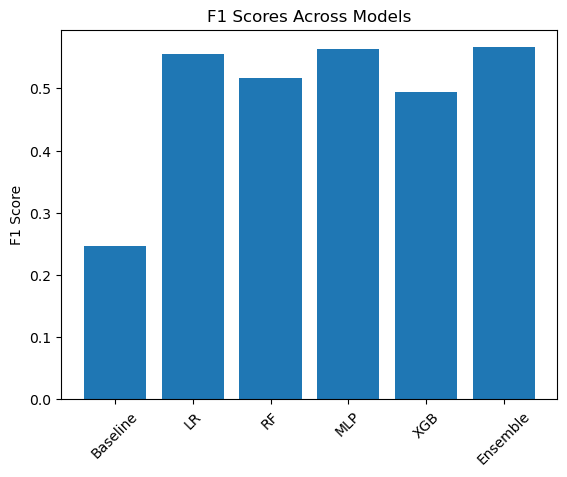

In [144]:
model_names = ['Baseline', 'LR', 'RF', 'MLP', 'XGB', 'Ensemble']
f1_scores = [baseline_f1, lr_f1, rf_f1, mlp_f1, xgb_1_f1, stack_2_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title('F1 Scores Across Models')
plt.show()

## Comparison with the All-Year Models

In [146]:
all_yr_lr = joblib.load("models/all_yr_best_logistic_regression.pkl")
all_yr_rf = joblib.load("models/all_yr_best_random_forest.pkl")
all_yr_xg = joblib.load("models/all_yr_xgb_model.pkl")
all_yr_stack = joblib.load("models/all_yr_stacking_2.pkl")

In [147]:
all_yr_lr_f1 = f1_score(y_test, all_yr_lr.predict(X_test), average='macro')
all_yr_rf_f1 = f1_score(y_test, all_yr_rf.predict(X_test), average='macro')
all_yr_xg_f1 = f1_score(y_test, all_yr_xg.predict(X_test), average='macro')
all_yr_stack_f1 = f1_score(y_test, all_yr_stack.predict(X_test), average='macro')

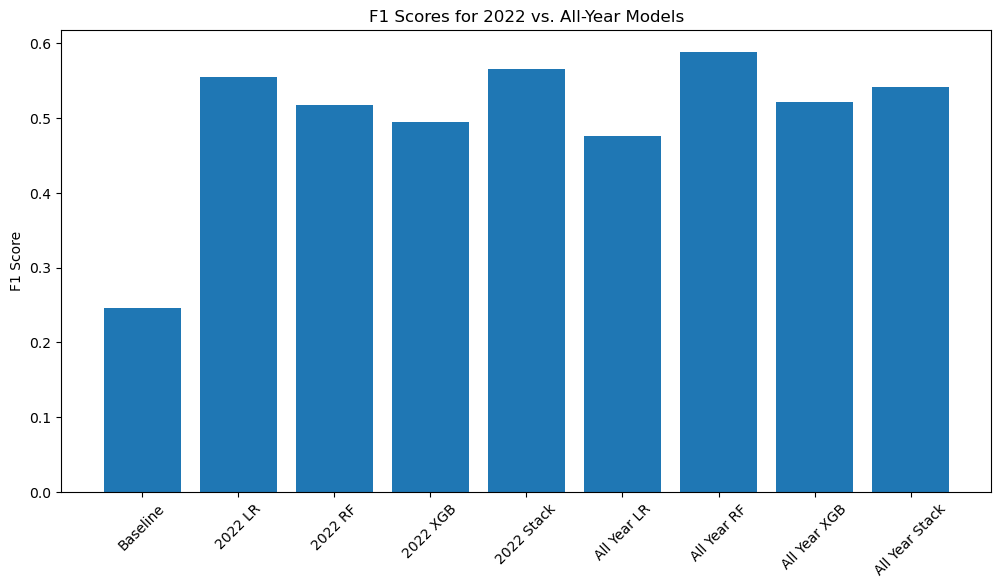

In [148]:
plt.figure(figsize=(12, 6))  # Adjust the width (12) and height (6) as needed

model_names = ['Baseline', f'{year} LR', f'{year} RF', f'{year} XGB', f'{year} Stack', 'All Year LR', 'All Year RF', 'All Year XGB', 'All Year Stack']
f1_scores = [baseline_f1, lr_f1, rf_f1, xgb_1_f1, stack_2_f1, all_yr_lr_f1, all_yr_rf_f1, all_yr_xg_f1, all_yr_stack_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. All-Year Models')
plt.show()

## 2022 vs. Non-2022 Models

In [150]:
other_years = [y for y in range(2013, 2025) if str(y) != year]
other_years

[2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2023, 2024]

In [151]:
other_years_df = model_utils.load_data(other_years)
model_utils.transform_offense_date(other_years_df)
dispo_mapping = model_utils.calc_dispo_subset(other_years_df)
all_police_df.shape

(294515, 24)

In [152]:
other_years_clean = model_utils.clean_and_transform_data(other_years_df)
other_years_clean.shape

Police Calls Dataset: 3292342 rows before cleaning, 2938245 rows after cleaning.


(2938245, 15)

In [153]:
X_train_oy, X_test_oy, y_train_oy, y_test_oy, _, _, X_train_resampled_oy, y_train_resampled_oy, _ = \
    model_utils.split_data(other_years_clean, dispo_mapping, encoder)

classes = ['A' 'B' 'C' 'Other']
(2350596, 14)
(587649, 14)
['Arrest Made', 'Arrest by Warrant', 'Criminal Citation', 'Other']


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Counter({3: 2253446, 0: 49347, 2: 27067, 1: 20736})
Counter({3: 97150, 0: 49347, 2: 27067, 1: 20736})


In [154]:
rf_model_oy = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs = -1)
rf_model_oy.fit(X_train_oy, y_train_oy)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

In [155]:
y_pred_rf_oy = rf_model_oy.predict(X_test_oy)

print(f"Random Forest Other Years Classification Report for Non-{year} Data:")
print(classification_report(y_test_oy, y_pred_rf_oy, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for Non-2022 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.55      0.38      0.45     12337
Arrest by Warrant       0.69      0.54      0.60      5184
Criminal Citation       0.46      0.22      0.30      6767
            Other       0.98      0.99      0.98    563361

         accuracy                           0.97    587649
        macro avg       0.67      0.53      0.58    587649
     weighted avg       0.96      0.97      0.96    587649



In [156]:
y_pred_rf_oy_2022 = rf_model_oy.predict(X_test)

print(f"Random Forest Other Years Classification Report for {year} Data:")
print(classification_report(y_test, y_pred_rf_oy_2022, zero_division=0, target_names=label_names))

Random Forest Other Years Classification Report for 2022 Data:
                   precision    recall  f1-score   support

      Arrest Made       0.55      0.25      0.35       813
Arrest by Warrant       0.66      0.43      0.53       384
Criminal Citation       0.48      0.17      0.25       406
            Other       0.98      1.00      0.99     50941

         accuracy                           0.97     52544
        macro avg       0.67      0.46      0.53     52544
     weighted avg       0.97      0.97      0.97     52544



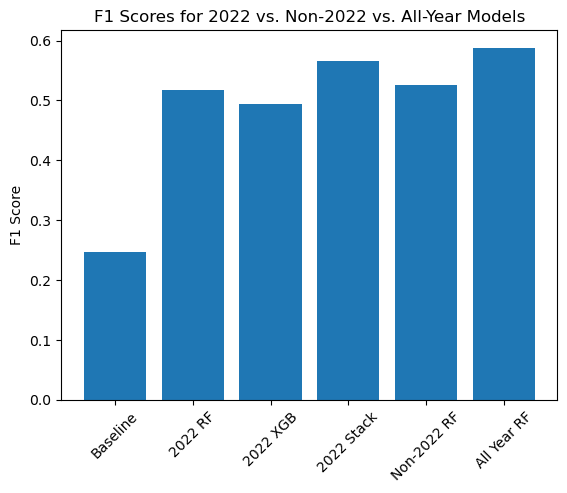

In [157]:
model_names = ['Baseline', f'{year} RF', f'{year} XGB', f'{year} Stack', f'Non-{year} RF', 'All Year RF']
f1_scores = [baseline_f1, rf_f1, xgb_1_f1, stack_2_f1, f1_score(y_test, y_pred_rf_oy_2022, average='macro'), all_yr_rf_f1]
plt.bar(model_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel('F1 Score')
plt.title(f'F1 Scores for {year} vs. Non-{year} vs. All-Year Models')
plt.show()